In [1]:

import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [30]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/sharvarisoparkar/Desktop/MiniProject/CornDetection",
    seed=10,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7316 files belonging to 4 classes.


In [6]:

class_names =dataset.class_names
class_names

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[0 1 2 0 2 1 1 2 1 2 2 0 0 0 0 3 0 0 2 2 0 3 0 3 3 3 1 3 2 3 1 3]


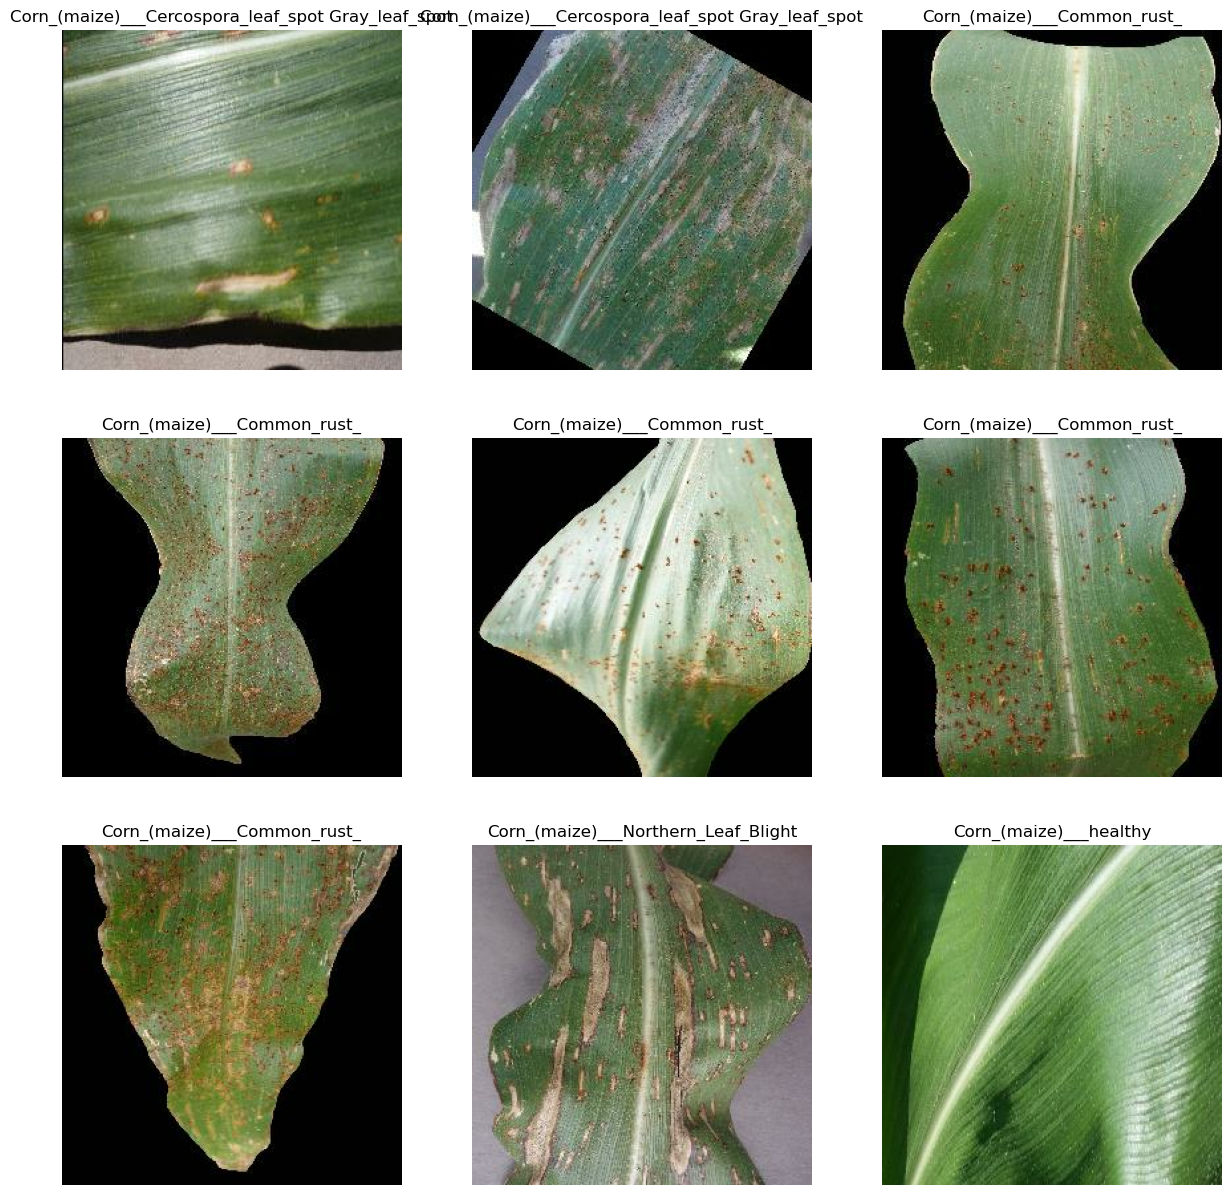

In [8]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

229

In [10]:
train_size = 0.8
len(dataset)*train_size

183.20000000000002

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

175

In [12]:
val_size=0.1
len(dataset)*val_size

22.900000000000002

In [15]:

val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

169

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [19]:
len(train_ds)

183

In [20]:
len(val_ds)

22

In [21]:
len(test_ds)

24

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])


In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (12, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (12, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (12, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (12, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (12, 60, 60, 64)         

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:


history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)



Epoch 1/5
183/183 [==============================] - 255s 1s/step - loss: 0.5853 - accuracy: 0.7181 - val_loss: 0.7237 - val_accuracy: 0.7145
Epoch 2/5
183/183 [==============================] - 312s 2s/step - loss: 0.3206 - accuracy: 0.8630 - val_loss: 0.4566 - val_accuracy: 0.8452
Epoch 3/5
183/183 [==============================] - 645s 4s/step - loss: 0.2446 - accuracy: 0.9037 - val_loss: 0.3636 - val_accuracy: 0.8949
Epoch 4/5
183/183 [==============================] - 883s 5s/step - loss: 0.1843 - accuracy: 0.9290 - val_loss: 0.2396 - val_accuracy: 0.9318
Epoch 5/5
183/183 [==============================] - 535s 3s/step - loss: 0.1409 - accuracy: 0.9433 - val_loss: 0.2548 - val_accuracy: 0.9332


In [39]:
scores = model.evaluate(test_ds)

24/24 [==============================] - 22s 733ms/step - loss: 0.1600 - accuracy: 0.9392


In [40]:
scores

[0.16001743078231812, 0.9391534328460693]

first image to predict
actual label: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
1/1 [==============================] - 2s 2s/step
predicted label: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


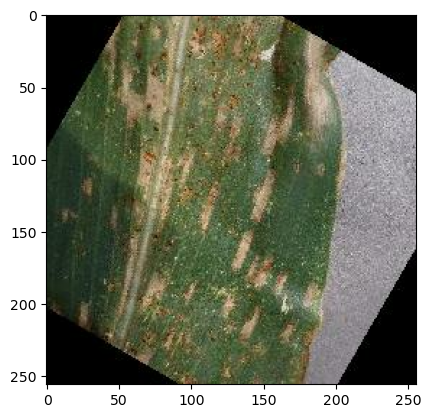

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])



In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 79ms/step


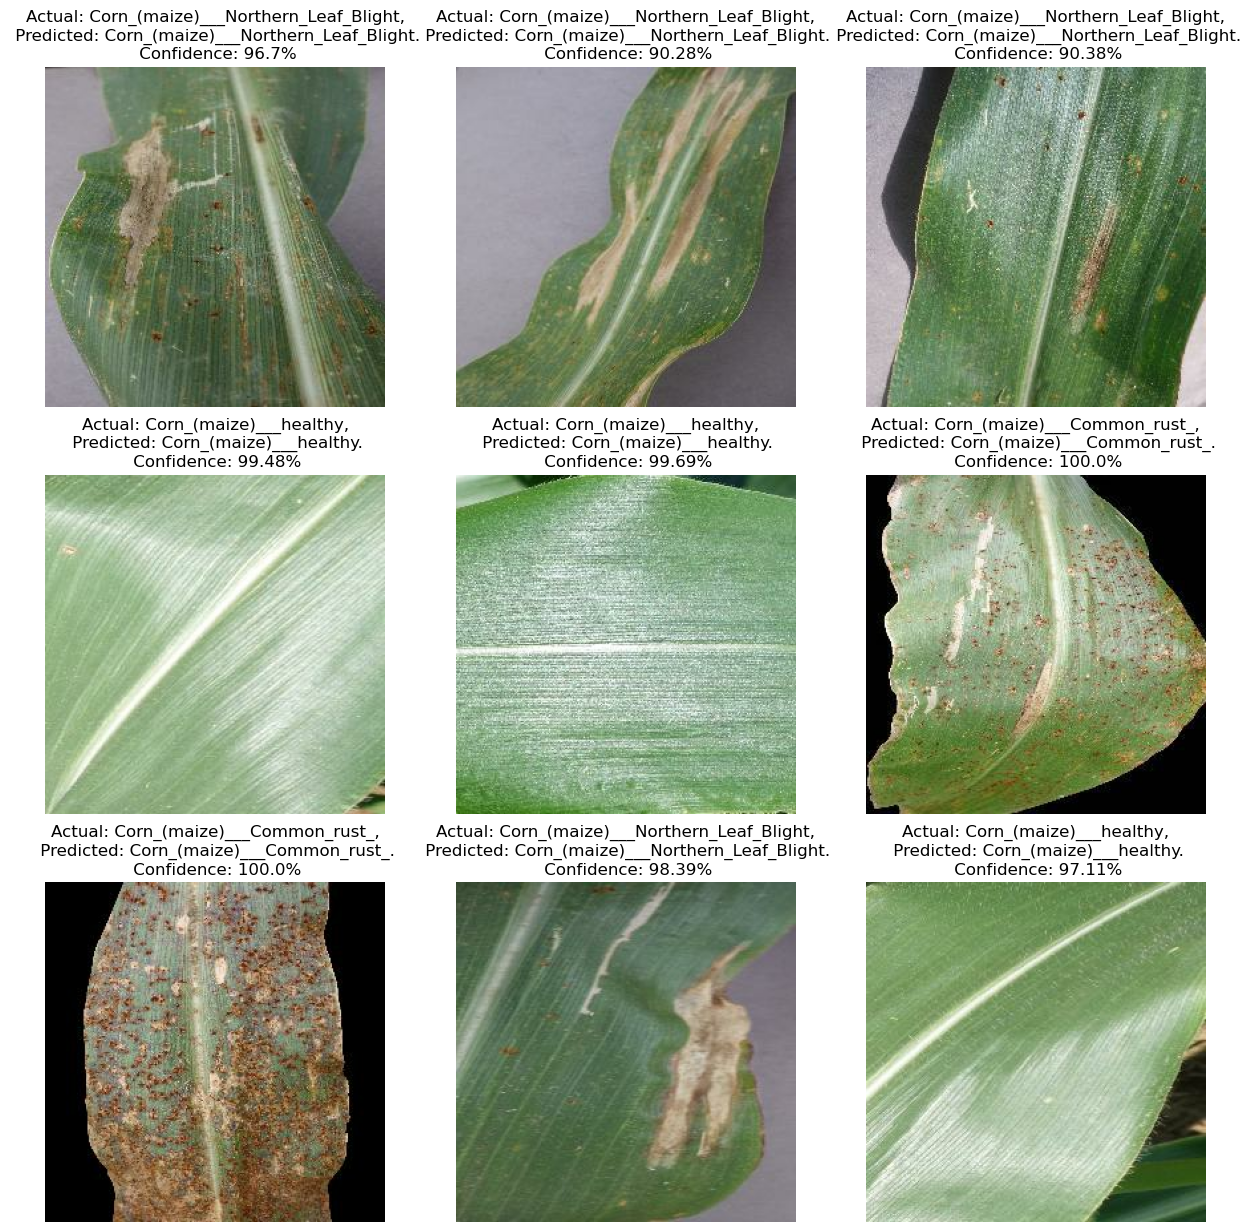

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [44]:
model_version=5
model.save(f'/Users/sharvarisoparkar/Desktop/MiniProject/Models/{model_version}')

INFO:tensorflow:Assets written to: /Users/sharvarisoparkar/Desktop/MiniProject/Models/5/assets


INFO:tensorflow:Assets written to: /Users/sharvarisoparkar/Desktop/MiniProject/Models/5/assets
